In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

In [2]:
def plot_elbow_graph(X, max_k=25):
    inertias = []
    K = range(1, max_k)

    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X)

        inertias.append(kmeanModel.inertia_)

    plt.plot(K, inertias, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method using Inertia')
    plt.show()

def dimension_reduction(X):

    pca = PCA(n_components=2, random_state=42)

    pca_vecs = pca.fit_transform(X)

    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]
    
    return x0, x1

def plot_pca(X, cluster_name):

    plt.figure(figsize=(12, 7))

    plt.title(f"Visualize Clusters", fontdict={"fontsize": 18})
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})
    
    x0, x1 = dimension_reduction(X)

    sns.scatterplot(x=x0, y=x1, hue=cluster_name, palette="viridis")
    plt.show()

def plot_route(df, title):
    geometry = [Point(xy) for xy in zip(df['Longitude (Degrees)'], df['Latitude (Degrees)'])]
    gdf = GeoDataFrame(df, geometry=geometry)

    # after visual inspection of the clusters, cluster 0, 4, 5 are clubbed together. 1, 2, 3, 6 are clubbed together
    color = []
    for c in df['Cluster']:
        if (c==0) or (c==4) or (c==5):
            color.append('blue')
        if (c==1) or (c==2) or (c==3) or (c==6):
            color.append('red')

    world = gpd.read_file(geodatasets.data.naturalearth.land['url'])
    ax = gdf.plot(ax=world.plot(figsize=(16, 8)), marker='o', color=color, markersize=1)
    padding = 60
    minx, miny, maxx, maxy = gdf.total_bounds
    ax.set_xlim(minx-padding, maxx+padding)
    ax.set_ylim(miny-padding, maxy+20)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [3]:
df_vessel1 = pd.read_csv('../data/data_vessel1.csv')
df_vessel2 = pd.read_csv('../data/data_vessel2.csv')

In [4]:
scaler = StandardScaler()
X = scaler.fit_transform(df_vessel1.drop(['Longitude (Degrees)', 'Latitude (Degrees)'], axis=1))
X2 = scaler.transform(df_vessel2.drop(['Longitude (Degrees)', 'Latitude (Degrees)'], axis=1))

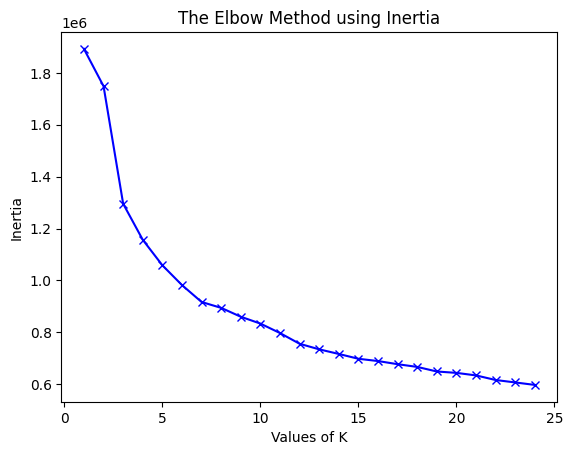

In [6]:
plot_elbow_graph(X)

In [7]:
kmeanModel = KMeans(n_clusters=7, random_state=42).fit(X)
kmeanModel.fit(X)

df_vessel1['Cluster'] = kmeanModel.predict(X)
df_vessel2['Cluster'] = kmeanModel.predict(X2)

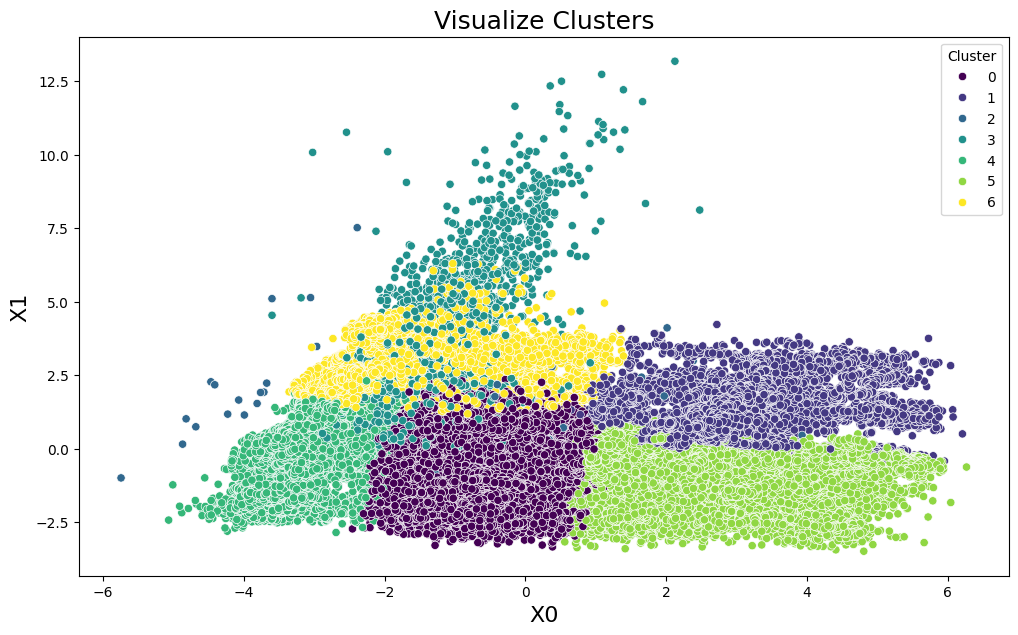

In [8]:
plot_pca(X, df_vessel1['Cluster'])

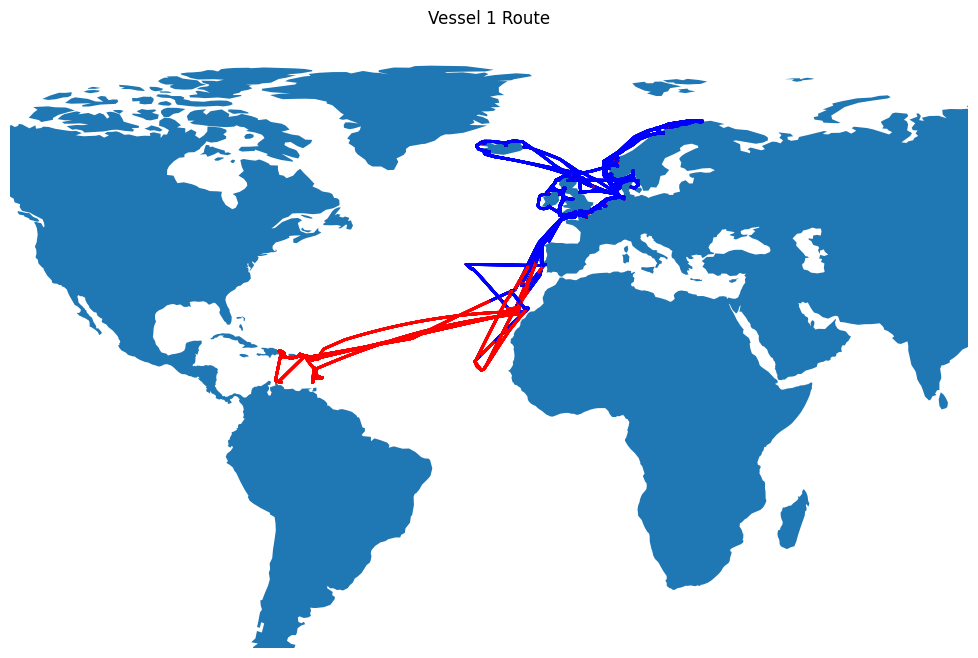

In [9]:
plot_route(df_vessel1, title='Vessel 1 Route')

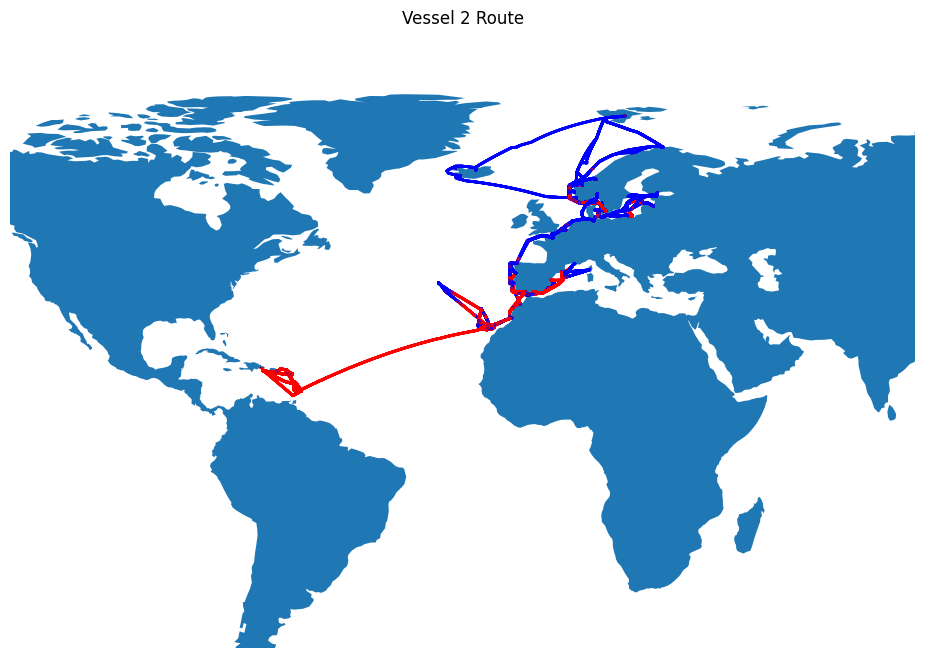

In [10]:
plot_route(df_vessel2, "Vessel 2 Route")

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, df_vessel1["Cluster"], test_size=0.25, stratify=df_vessel1["Cluster"], random_state=42)

clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

print('Important Features')
feature_importances = pd.Series(clf.feature_importances_, index=df_vessel1.drop(['Longitude (Degrees)', 'Latitude (Degrees)', 'Cluster'], axis=1).columns)
print(feature_importances.sort_values(ascending=False)[:5])

print(classification_report(y_test, clf.predict(X_test)))

Important Features
Power Galley (MW)                    0.146415
Sea Temperature (Celsius)            0.138925
Diesel Generator Power (MW)          0.109070
HVAC Chiller Power (MW)              0.108595
Main Engine Fuel Flow Rate (kg/h)    0.076971
dtype: float64
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6773
           1       1.00      0.99      0.99      3675
           2       1.00      0.80      0.89        15
           3       0.96      0.96      0.96       537
           4       0.99      0.99      0.99      6722
           5       0.99      0.99      0.99      6774
           6       0.99      0.97      0.98      1784

    accuracy                           0.99     26280
   macro avg       0.99      0.96      0.97     26280
weighted avg       0.99      0.99      0.99     26280

